# **Neural Network + Particle Swarm Optimisation**

## **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             precision_score, recall_score, f1_score, roc_auc_score, roc_curve)

## **Read Dataset**

In [2]:
# Load the dataset that has been preprocessed
data = pd.read_csv('dataset/preprocessed_breast-cancer.csv')

# Extract features (X) and target (y) from the dataset
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values.reshape(-1, 1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Neural Network Essentials**

### **Configure Network Architecture**

In [3]:
input_layer = X_train.shape[1]
hidden_layer = 16

### **Initialise Weights and Biases**

In [4]:
np.random.seed(42)

# Create weight and bias for the hidden layer
W1 = np.random.randn(input_layer, hidden_layer) * 0.01
b1 = np.zeros((1, hidden_layer))

# Create weight and bias for the output layer
W2 = np.random.randn(hidden_layer, 1) * 0.01
b2 = np.zeros((1, 1))

### **Activation Functions**

In [5]:
def relu(Z):
    """Rectified Linear Unit activation function"""
    return np.maximum(0, Z)

def sigmoid(Z):
    """Sigmoid activation function for output layer"""
    return 1 / (1 + np.exp(-Z))

### **Forward Propagation**

In [6]:
def forward_pass(X, W1, b1, W2, b2):
    """Calculate neural network outputs through forward propagation"""
    Z1 = np.dot(X, W1) + b1     # Linear combination for hidden layer
    A1 = relu(Z1)               # Activation for hidden layer
    Z2 = np.dot(A1, W2) + b2    # Linear combination for output layer
    A2 = sigmoid(Z2)            # Activation for output layer
    
    return Z1, A1, Z2, A2

### **Loss Calculation**

In [7]:
def compute_loss(y_true, y_pred):
    """Calculate binary cross-entropy loss with numerical stability"""
    return -np.mean(y_true * np.log(y_pred + 1e-8) + (1 - y_true) * np.log(1 - y_pred + 1e-8))

## **Particle Swarm Optimisation Essentials**

### **Initialise PSO**

In [8]:
class PSO:
    """Implementing the Particle Swarm Optimization for parameter search"""
    def __init__(self, n_particles, dimensions, inertia=0.729844, cognitive=1.49618, social=1.49618):
        # Hyperparameters
        self.n_particles = n_particles      # Number of particles in swarm
        self.dimensions = dimensions        # Dimensionality of search space (total NN parameters)
        self.inertia = inertia              # Momentum factor
        self.cognitive = cognitive          # Cognitive coefficient (personal best influence)
        self.social = social                # Social coefficient (global best influence)
        
        # Initialise the swarm
        self.particles = np.random.randn(n_particles, dimensions) * 0.01    # Initial positions
        self.velocities = np.zeros((n_particles, dimensions))               # Initial velocities
        self.best_positions = self.particles.copy()                         # Personal best positions
        self.best_scores = np.full(n_particles, np.inf)                     # Personal best scores
        self.global_best_position = None                                    # Global best position
        self.global_best_score = np.inf                                     # Global best score

    def update(self, fitness_func):
        """Update swarm positions and velocities for one iteration"""

        # Update personal and global bests
        for i in range(self.n_particles):
            current_score = fitness_func(self.particles[i])
            
            if current_score < self.best_scores[i]:
                self.best_scores[i] = current_score
                self.best_positions[i] = self.particles[i].copy()
                
                if current_score < self.global_best_score:
                    self.global_best_score = current_score
                    self.global_best_position = self.particles[i].copy()
        
        # Update velocities and positions
        for i in range(self.n_particles):
            r1, r2 = np.random.rand(self.dimensions), np.random.rand(self.dimensions)

            cognitive = self.cognitive * r1 * (self.best_positions[i] - self.particles[i])
            social = self.social * r2 * (self.global_best_position - self.particles[i])
            
            self.velocities[i] = self.inertia * self.velocities[i] + cognitive + social
            self.particles[i] += self.velocities[i]

### **Parameter Conversion Functions**

In [9]:
def flatten_params(W1, b1, W2, b2):
    """Convert the neural network parameters to 1D vector"""
    return np.concatenate([W1.flatten(), b1.flatten(), W2.flatten(), b2.flatten()])

In [10]:
def unflatten_params(vector, input_layer, hidden_layer):
    """Convert the 1D vector back to neural network parameters"""
    
    # Calculate parameter sizes
    W1_size = input_layer * hidden_layer
    b1_size = hidden_layer
    W2_size = hidden_layer * 1
    b2_size = 1
    
    # Extract and reshape parameters
    W1 = vector[:W1_size].reshape(input_layer, hidden_layer)
    b1 = vector[W1_size:W1_size+b1_size].reshape(1, hidden_layer)
    
    W2 = vector[W1_size+b1_size:W1_size+b1_size+W2_size].reshape(hidden_layer, 1)
    b2 = vector[W1_size+b1_size+W2_size:].reshape(1, 1)
    
    return W1, b1, W2, b2

### **Fitness Function**

In [11]:
def fitness_function(particle):
    """Calculate the loss for PSO particle's parameters"""
    W1, b1, W2, b2 = unflatten_params(particle, input_layer, hidden_layer)
    _, _, _, A2 = forward_pass(X_train, W1, b1, W2, b2)
    
    return compute_loss(y_train, A2)    # calculate and return lower loss for better fitness

## **Model Training**

In [12]:
epochs = 50
n_particles = 30

init_params = flatten_params(W1, b1, W2, b2)
pso = PSO(n_particles=n_particles, dimensions=len(init_params))

In [13]:
# Scale the training data and apply it to testing data as well
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Split the dataset again into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Track the training history for plotting
history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

In [14]:
print(f"{'Epoch':^9} | {'Loss':^10} | {'Acc':^9} | {'Val Loss':^10} | {'Val Acc':^9}")
print("-" * 62)

for epoch in range(epochs):
    # Update the swarm positions and velocities
    pso.update(fitness_function)
    
    # Extract the best parameters from the global best position
    best_params = pso.global_best_position
    W1, b1, W2, b2 = unflatten_params(best_params, input_layer, hidden_layer)
    
    # Calculate training metrics
    _, _, _, A2_train = forward_pass(X_train, W1, b1, W2, b2)
    train_loss = compute_loss(y_train, A2_train)
    train_acc = np.mean((A2_train > 0.5).astype(int) == y_train)
    
    # Calculate validation metrics
    _, _, _, A2_val = forward_pass(X_val, W1, b1, W2, b2)
    val_loss = compute_loss(y_val, A2_val)
    val_acc = np.mean((A2_val > 0.5).astype(int) == y_val)
    
    # Store the training history
    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    
    print(f"{f'{epoch+1:3d}/{epochs:3d}':^9} | "
          f"{train_loss:10.4f} | "
          f"{train_acc:9.4f} | "
          f"{val_loss:10.4f} | "
          f"{val_acc:9.4f}")

  Epoch   |    Loss    |    Acc    |  Val Loss  |  Val Acc 
--------------------------------------------------------------
   1/ 50  |     0.6885 |    0.6346 |     0.6896 |    0.6044
   2/ 50  |     0.6872 |    0.6346 |     0.6886 |    0.6044
   3/ 50  |     0.6830 |    0.6346 |     0.6855 |    0.6044
   4/ 50  |     0.6771 |    0.6346 |     0.6813 |    0.6044
   5/ 50  |     0.6717 |    0.6346 |     0.6776 |    0.6044
   6/ 50  |     0.6666 |    0.6346 |     0.6746 |    0.6044
   7/ 50  |     0.6615 |    0.6346 |     0.6721 |    0.6044
   8/ 50  |     0.6575 |    0.6346 |     0.6716 |    0.6044
   9/ 50  |     0.6561 |    0.6346 |     0.6724 |    0.6044
  10/ 50  |     0.6556 |    0.6346 |     0.6717 |    0.6044
  11/ 50  |     0.6546 |    0.6346 |     0.6721 |    0.6044
  12/ 50  |     0.6530 |    0.6346 |     0.6704 |    0.6044
  13/ 50  |     0.6512 |    0.6346 |     0.6687 |    0.6044
  14/ 50  |     0.6467 |    0.6346 |     0.6626 |    0.6044
  15/ 50  |     0.6415 |    0.6346 | 

## **Model Evaluation**

In [15]:
# Make predictions on test set (convert probabilities to binary)
_, _, _, y_pred_probs = forward_pass(X_test, W1, b1, W2, b2)
y_pred = (y_pred_probs > 0.5).astype(int).ravel()

test_accuracy = np.mean(y_pred == y_test.ravel())
print(f"\nTest Accuracy: {test_accuracy:.4f}\n")


Test Accuracy: 0.9737



In [16]:
average_precision = precision_score(y_test, y_pred, average='macro')
average_recall = recall_score(y_test, y_pred, average='macro')
average_f1 = f1_score(y_test, y_pred, average='macro')

print(f"Average Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")
print(f"Average F1-Score: {average_f1:.4f}")

Average Precision: 0.9797
Average Recall: 0.9651
Average F1-Score: 0.9716


In [17]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        71
           1       1.00      0.93      0.96        43

    accuracy                           0.97       114
   macro avg       0.98      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



## **Visualisation**

### **Confusion Matrix**

<Figure size 800x600 with 0 Axes>

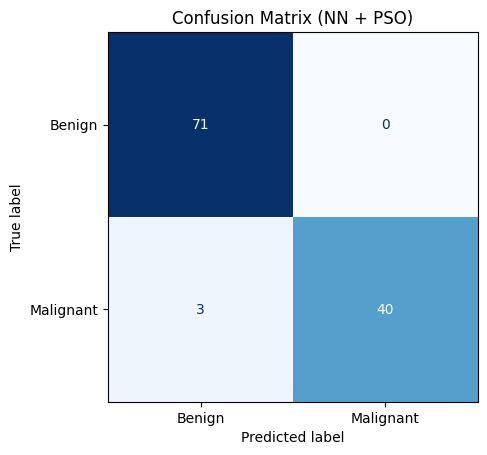

In [18]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])

plt.figure(figsize=(8, 6))

disp.plot(cmap=plt.cm.Blues, values_format="d", colorbar=False)
plt.title("Confusion Matrix (NN + PSO)")

plt.show()

### **Accuracy of Training and Validation**

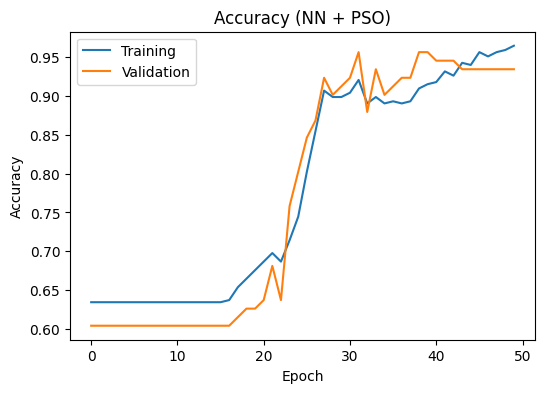

In [19]:
plt.figure(figsize=(6, 4))

plt.title('Accuracy (NN + PSO)')
plt.plot(history['accuracy'], label='Training')
plt.plot(history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

### **Loss of Training and Validation**

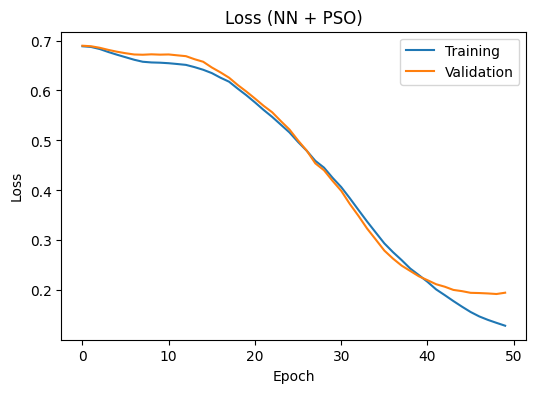

In [20]:
plt.figure(figsize=(6, 4))

plt.title('Loss (NN + PSO)')
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

### **Distribution of Predicted Probabilities**

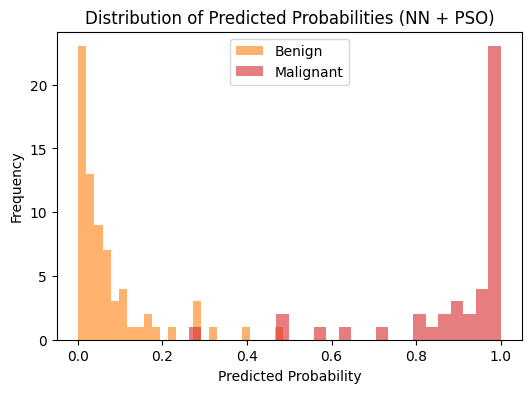

In [21]:
plt.figure(figsize=(6, 4))

plt.title('Distribution of Predicted Probabilities (NN + PSO)')
plt.hist(y_pred_probs[y_test.ravel() == 0], bins=25, alpha=0.6, color='tab:orange', label='Benign')
plt.hist(y_pred_probs[y_test.ravel() == 1], bins=25, alpha=0.6, color='tab:red', label='Malignant')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

plt.legend()
plt.show()

### **Receiver Operating Characteristic (ROC) Curve**

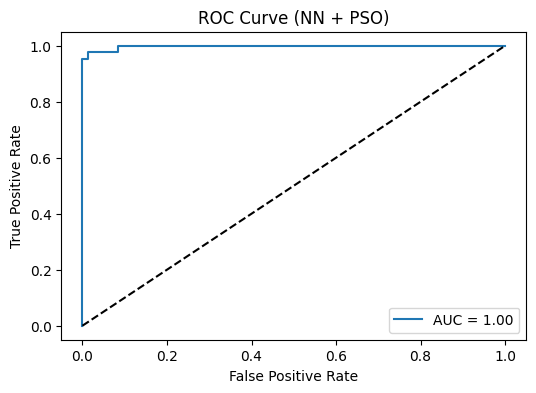

In [22]:
roc_auc = roc_auc_score(y_test, y_pred_probs)
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)

plt.figure(figsize=(6, 4))

plt.title('ROC Curve (NN + PSO)')
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()